In [1]:
base_dir = 'results/'
dir_individual = base_dir + 'individual/'
dir_randomization = base_dir + 'randomization/'
census_file = base_dir + 'pums_2019.csv'

In [2]:
import os
from tqdm import tqdm

import math
import numpy as np
import pandas as pd
from scipy.stats import chisquare

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

bcolor = sb.color_palette('husl')[-2]
gcolor = sb.color_palette('husl')[2]
ocolor = sb.color_palette('muted')[1]

### Load responses

In [3]:
from plot_utils.models import model_names, instruct, model_sizes, hf_models

all_models = sorted(hf_models, key=lambda x: model_sizes[x])
base_models = sorted(list(set(all_models) - set(instruct.keys())), key=lambda x: model_sizes[x])

In [4]:
from plot_utils.plot_utils import acs_categories as n_categories
from plot_utils.plot_utils import load_acs_census_responses
from surveying_llms.load_responses import load_naive_responses, load_adjusted_responses

variables = list(n_categories.keys())
uniform_responses = {var: np.ones(n_categories[var]) / n_categories[var] for var in variables}
census_responses = load_acs_census_responses(census_file, n_categories)
naive_responses = load_naive_responses(dir_individual, base_models, n_categories)
_, adjusted_responses = load_adjusted_responses(dir_individual, all_models, n_categories)

Loading naive responses...


100%|██████████| 20/20 [00:00<00:00, 315.65it/s]


Loading adjusted responses...


100%|██████████| 33/33 [00:02<00:00, 12.86it/s]


In [5]:
from plot_utils.plot_utils import compute_entropy, compute_kl

uniform_entropies = {var: compute_entropy(uniform_responses[var]) for var in variables}
census_norm_entropies = {v: compute_entropy(census_responses[v]) / uniform_entropies[v] for v in variables}
naive_norm_entropies = {v: {m: compute_entropy(naive_responses[v][m]) / uniform_entropies[v] 
                            for m in base_models} for v in variables}
adjusted_norm_entropies = {v: {m: compute_entropy(adjusted_responses[v][m]) / uniform_entropies[v] 
                            for m in all_models} for v in variables}


kl_uniform_census = {v: compute_kl(uniform_responses[v], census_responses[v]) for v in variables}
adjusted_kl_census = {v: {m: compute_kl(adjusted_responses[v][m], census_responses[v])
                   for m in all_models} for v in variables}
adjusted_kl_uniform = {v: {m: compute_kl(adjusted_responses[v][m], uniform_responses[v])
                   for m in all_models} for v in variables}

### Appendix B

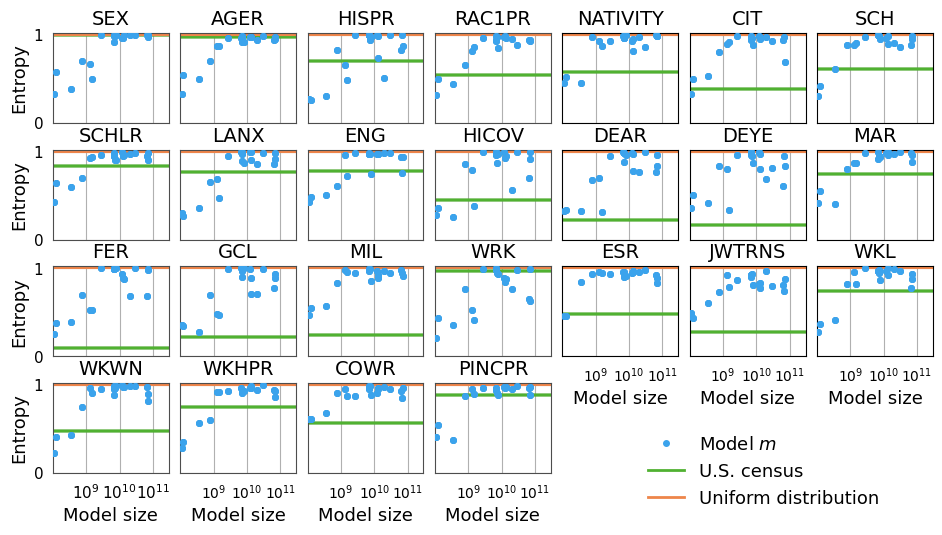

In [6]:
def appendix_b_plot(plot_entropies):
    dfig, ax = plt.subplots(4, 7, figsize=(11, 5.5), sharey=True, sharex=False)

    msize = 7
    sizes = [model_sizes[m] for m in base_models]
    for i, var in enumerate(variables):
        entropies = [plot_entropies[var][m] for m in base_models]
        for model in base_models:
            cens_ent = census_norm_entropies[var]
            ax[i//7, i%7].plot([1e7, 1e12], [cens_ent, cens_ent], c=gcolor)
            ax[i//7, i%7].set_title(var, fontsize=14)
            ax[i//7, i%7].plot(sizes, entropies, '.', c=bcolor, markersize=msize, zorder=10)

        ax[i//7, i%7].xaxis.set_ticks_position('none') 
        ax[i//7, i%7].yaxis.set_ticks_position('none') 
        for spine in ax[i//7, i%4].spines.values():
            spine.set_edgecolor('0.3')
    
    for i in range(4):
        for j in range(7):
            ax[i, j].set_xscale('log')
            ax[i, j].set_xlim([1e8, 3e11])
            ax[i, j].set_ylim([0, 1.02])
            ax[i, j].set_xticks([1e9, 1e10, 1e11])
            if i*7 + j <= 17:
                ax[i,j].set_xticklabels([])

    # x and y labels
    for i in range(4):
        ax[i, 0].set_ylabel('Entropy', fontsize=13)
        ax[-1, i].set_xlabel('Model size', fontsize=13)
        ax[i, 0].tick_params(axis='both', which='major', labelsize=11)
        
        for j in range(7):
            if i*7 + j >= 25:
                continue
            ax[i, j].grid()
            ax[i, j].plot([1e7, 1e12], [1, 1], c=ocolor)
            
            
    
    for i in range(4):
        for j in range(7):
            ax[i, j].tick_params(bottom=False)
            
    for i in range(4, 7):
        ax[-2, i].set_xlabel('Model size', fontsize=13)
        ax[-2, i].tick_params(axis='both', which='major', labelsize=10)
            
    for j in range(4, 7):
        ax[-1, j].axis('off')
    
    legend_elements = []
    legend_elements.append(plt.Line2D([0], [0], marker='.', color=bcolor, 
                                      label='Model $m$', markersize=msize+1, 
                                      markerfacecolor=bcolor, lw=0))
    legend_elements.append(plt.Line2D([0], [0], color=gcolor, 
                                      label='U.S. census', markersize=msize+1, 
                                      markerfacecolor=gcolor, lw=2))
    legend_elements.append(plt.Line2D([0], [0], color=ocolor, 
                                      label='Uniform distribution', markersize=msize+1, 
                                      markerfacecolor=ocolor, lw=2))

    legend_position = (-1.6, -0.7)  # Coordinates (x, y) for top left position
    ax[2, -1].legend(handles=legend_elements, loc='upper left', 
              bbox_to_anchor=legend_position, frameon=False, ncols=1, fontsize=13, columnspacing=1.)
    
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.3)

appendix_b_plot(naive_norm_entropies)
plt.savefig('plots/all_vars-unadj.pdf', bbox_inches='tight')

### Appendix C

In [7]:
base_hf_models = ['gpt2', 'gpt2m', 'gpt2l', 'gpt2xl',
                  'gptneo125m', 'gptneo1.3b', 'gptneo2.7b',
                  'mpt', 'pythia7', 'pythia12', 'gptneox',
                  'llama7b', 'llama13b', 'llama30b',
]
base_hf_models = sorted(base_hf_models, key=lambda x: model_sizes[x])

In [8]:
def col2freq(col, n_cats, assign_nan=None, normalize=True, weight=None):
    """
    Inputs a pandas frame and extracts the relative frequency of each choice.
    If assign_nan is an int, then assign its rel. freq. to such choice.
    """
    p = np.zeros(n_cats)

    if weight is None:
        freqs = col.value_counts(dropna=assign_nan is None, normalize=normalize)
    else:
        df = pd.concat([col, weight], axis=1)
        freqs = df.groupby(col.name, dropna=assign_nan is None)[weight.name].sum()
        if normalize:
            freqs = freqs / freqs.sum()

    for choice, prob in freqs.items():
        if not math.isnan(choice):
            p[int(choice) - 1] = prob

    if assign_nan is not None:
        p[assign_nan - 1] += freqs[float('nan')]
    return p

def letter2freq(col, n_cats, letters, normalize=True):
    freqs = np.array([(col == l).sum() for l in letters[:n_cats]])
    if normalize:
        freqs = freqs / freqs.sum()
    return freqs

p_sig = 0.05
def do_chi_test_uniform(observed_freq):
    expected_freq = np.ones_like(observed_freq) / len(observed_freq) * np.sum(observed_freq)
    chi2_stat, p_value = chisquare(observed_freq, f_exp=expected_freq)
    return p_value < p_sig  # means not uniform

def plot_ordering_bias(data, xlabel, ax):
    for model in base_hf_models:
        ax.plot(model_sizes[model], data[model]*100, '.', c=bcolor)
    
    ax.set_ylim([50, 105])
    ax.set_xlim([1e8, 4e10])
    ax.set_xscale('log')
    ax.grid()
    ax.set_yticks([50, 75, 100])
    ax.set_xlabel('Model size', fontsize=11)
    ax.set_ylabel(xlabel, fontsize=11)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    for spine in ax.spines.values():
        spine.set_edgecolor('0.3')
        
def bias_plot(data, ylim, ylabel, ax):
    for i, model in enumerate(base_hf_models):
        ys = data[model]
        xs = [i for _ in ys]
        ax.plot(xs, ys, '.', c=bcolor, alpha=0.4, markersize=12)
    
    # unbiased line
    ax.plot([-0.5, len(base_hf_models)], [0, 0], '-', zorder=1, c=ocolor, linewidth=3.0)

    # legend
    legend_elements = []
    legend_elements.append(plt.Line2D([0], [0], color=ocolor, 
                                      label='Unbiased sampling', markersize=11, 
                                      markerfacecolor=ocolor, lw=3))
    legend_elements.append(plt.Line2D([0], [0], marker='.', color=bcolor, 
                                      label='Survey questions', markersize=11, 
                                      markerfacecolor=bcolor, lw=0))
    legend_position = (1., 1.3)  # Coordinates (x, y) for top left position
    ax.legend(handles=legend_elements, loc='upper right', frameon=False, bbox_to_anchor=legend_position, 
              ncols=2, handletextpad=.8,)

    # x-ticks
    dx = 0.2; dy = 0.05
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
    ax.set_xticks([i for i in range(len(base_hf_models))])
    labels = [model_names[m] for m in base_hf_models]
    ax.set_xticklabels(labels, rotation=25, ha='right', fontsize=10)

    ax.set_xlim([-0.4, len(base_hf_models)-0.5])
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', zorder=-10)
    ax.set_axisbelow(True)
    ax.set_ylim([-ylim, ylim])
    ax.set_ylabel(ylabel, fontsize=12)
    ax.tick_params(axis='y', which='both', labelsize=10)
    for spine in ax.spines.values():
        spine.set_edgecolor('0.3')

### Appendix C1

100%|██████████| 14/14 [00:00<00:00, 22.34it/s]


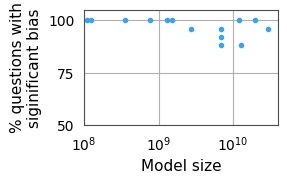

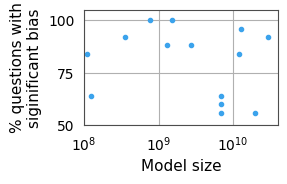

In [9]:
abc = [chr(65 + i) for i in range(26)]
order_freq = {m: {} for m in base_hf_models}
letter_freq = {m: {} for m in base_hf_models}
for model in tqdm(base_hf_models):
    df = pd.read_csv(dir_randomization+f"{model}_abc_rand_ca.csv")
    for var in variables:
        order_freq[model][var] = col2freq(df[var+'_order']+1, n_categories[var], normalize=False)
        letter_freq[model][var] = letter2freq(df[var+'_char'], n_categories[var], abc, normalize=False)

pct_significant_order = {m: np.mean([do_chi_test_uniform(order_freq[m][v])
                                     for v in variables]) for m in base_hf_models}
pct_significant_letter = {m: np.mean([do_chi_test_uniform(letter_freq[m][v])
                                     for v in variables]) for m in base_hf_models}

fig, ax = plt.subplots(figsize=(2.5, 1.5))
plot_ordering_bias(pct_significant_letter, '% questions with\nsiginificant bias', ax)
plt.savefig('plots/randomization_abc_letter_bias.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(2.5, 1.5))
plot_ordering_bias(pct_significant_order, '% questions with\nsiginificant bias', ax)
plt.savefig('plots/randomization_abc_ordering_bias.pdf', bbox_inches='tight')

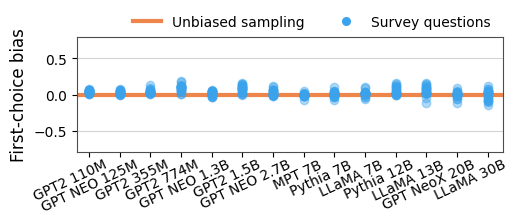

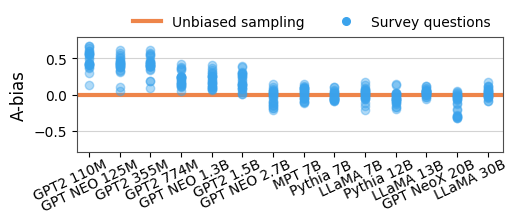

In [10]:
first_choice_bias = {m: [(order_freq[m][v][0] / order_freq[m][v].sum()) - (1. / order_freq[m][v].shape[0])
                         for v in variables] for m in base_hf_models}
a_bias = {m: [(letter_freq[m][v][0] / order_freq[m][v].sum()) - (1. / order_freq[m][v].shape[0])
                         for v in variables] for m in base_hf_models}

fig, ax = plt.subplots(figsize=(5.5, 1.5))
bias_plot(first_choice_bias, 0.8, 'First-choice bias', ax)
# plt.ylim([-0.02, 0.75])
plt.savefig('plots/randomization_first_choice_bias.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5.5, 1.5))
bias_plot(a_bias, 0.8, 'A-bias', ax)
# plt.ylim([-0.02, 0.75])
plt.savefig('plots/randomization_a_bias.pdf', bbox_inches='tight')

### Appendix C2

100%|██████████| 14/14 [00:00<00:00, 31.53it/s]


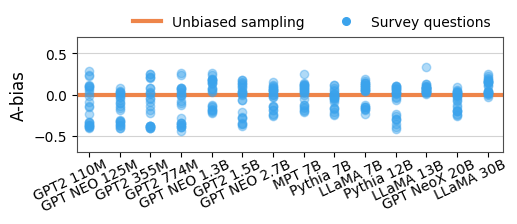

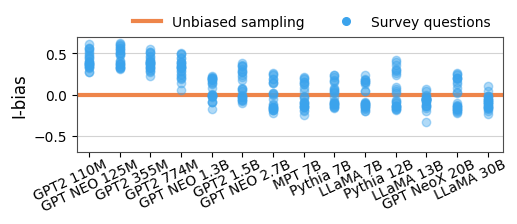

In [11]:
aic = [chr(65 + i) for i in range(26)]
aic[1] = 'I'
order_freq = {m: {} for m in base_hf_models}
letter_freq = {m: {} for m in base_hf_models}
for model in tqdm(base_hf_models):
    df = pd.read_csv(dir_randomization+f"{model}_aic_rand_ca.csv")
    for var in variables:
        letter_freq[model][var] = letter2freq(df[var+'_char'], n_categories[var], aic)
        
a_bias = {m: [letter_freq[m][v][0] - (1. / len(letter_freq[m][v]))
    for v in variables] for m in base_hf_models}
i_bias = {m: [letter_freq[m][v][1] - (1. / len(letter_freq[m][v]))
    for v in variables] for m in base_hf_models}

fig, ax = plt.subplots(figsize=(5.5, 1.5))
bias_plot(a_bias, 0.7, 'A-bias', ax)
# plt.ylim([-0.02, 0.75])
plt.savefig('plots/randomization_a_bias2.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5.5, 1.5))
bias_plot(i_bias, 0.7, 'I-bias', ax)
# plt.ylim([-0.02, 0.75])
plt.savefig('plots/randomization_i_bias.pdf', bbox_inches='tight')

### Appendix C3

100%|██████████| 14/14 [00:00<00:00, 30.90it/s]


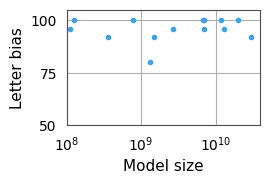

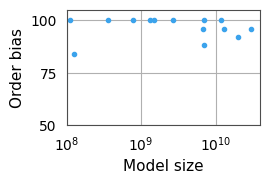

In [12]:
rsn = ['R', 'S', 'N', 'L', 'O', 'T', 'M', 'P', 'W', 'U', 'Y', 'V']
order_freq = {m: {} for m in base_hf_models}
letter_freq = {m: {} for m in base_hf_models}
for model in tqdm(base_hf_models):
    df = pd.read_csv(dir_randomization+f"{model}_rsn_rand_ca.csv")
    for var in variables:
        order_freq[model][var] = col2freq(df[var+'_order']+1, n_categories[var], normalize=False)
        letter_freq[model][var] = letter2freq(df[var+'_char'], n_categories[var], rsn, normalize=False)
        
pct_significant_letter = {m: np.mean([do_chi_test_uniform(letter_freq[m][v])
                                     for v in variables]) for m in base_hf_models}

pct_significant_order = {m: np.mean([do_chi_test_uniform(order_freq[m][v])
                                     for v in variables]) for m in base_hf_models}

fig, ax = plt.subplots(figsize=(2.5, 1.5))
plot_ordering_bias(pct_significant_letter, 'Letter bias', ax)
plt.savefig('plots/randomization_rsn_letter_bias.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(2.5, 1.5))
plot_ordering_bias(pct_significant_order, 'Order bias', ax)
plt.savefig('plots/randomization_rsn_order_bias.pdf', bbox_inches='tight')

### Sequential generation and discriminator test

In [13]:
base_dir = 'results/'
dir_discriminator = base_dir + 'discriminator_test/'

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
from plot_utils.plot_utils import plot_discriminator
from plot_utils.models import hf_models, model_names, model_sizes

discriminator_models = list(set(hf_models) - set(['mpt', 'mpt-chat', 'mpt-instruct'])) + ['gpt-4']
discriminator_models = sorted(discriminator_models, key=lambda x: model_sizes[x])

accuracies = {}  # summary
accuracies2 = {}  # unadjusted
for m in discriminator_models:
    file1 = f'{dir_discriminator}summary/{m}_accuracies.csv'
    if os.path.exists(file1):
        accuracies[m] = pd.read_csv(file1)['xgboost']
    
    file2 = f'{dir_discriminator}no-adjustment/{m}_accuracies.csv'
    if os.path.exists(file2):
        accuracies2[m] = pd.read_csv(file2)['xgboost']

# get the discriminator test metrics for discriminating U.S. states
s_acs = pd.read_csv(f'{dir_discriminator}/states_accuracies.csv')
s_acs = s_acs.groupby(['s'])['xgboost'].mean()
mean_s = s_acs.mean() * 100
lower_s = mean_s - 2 * s_acs.std() * 100
upper_s = mean_s + 2 * s_acs.std() * 100

[0.05986476426078966, 0.06569800225273269, 0.06386804756684009, 0.06350000000000143, 0.06341167085008807, 0.057540941945713235, 0.06270604037889767, 0.06681083370232681, 0.06380538770354732, 0.06960062858911488, 0.07822753671182679, 0.07829596557766604, 0.06792231811226206, 0.05826858072752367, 0.02866600774436633, 0.06926895047566445, 0.0708255603578257, 0.07346591046192877, 0.09266707883601372, 0.09678455455288242, 0.058632307646894255, 0.06021420098282583, 0.07402303695472046, 0.08238281070708793, 0.06976037557238286, 0.1406148907477434, 3.828317646173054]


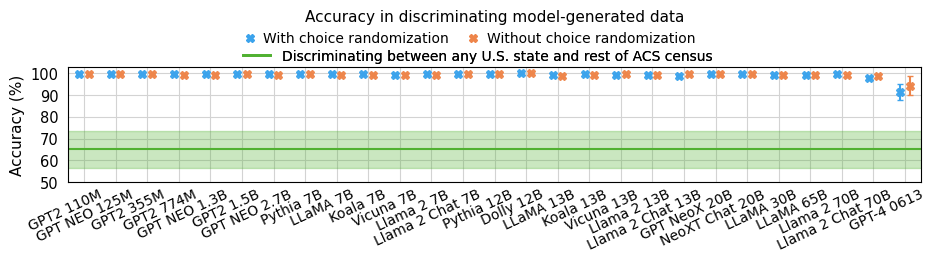

In [16]:
discriminator_models = set(accuracies.keys()) & set(accuracies2.keys())
discriminator_models = sorted(discriminator_models, key=lambda x: model_sizes[x])

plot_discriminator(accuracies, accuracies2, discriminator_models, model_names, 
                   figsize=(11., 1.5), legendx=0.75,
                   mean_s=mean_s, lower_s=lower_s, upper_s=upper_s)

plt.ylim([50, 103])
plt.savefig('plots/discriminator_test-all.pdf', bbox_inches='tight')